In [25]:
# =============================================================================
# Import Libraries and functions
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
import os
# from Design_Matrix import 
import matplotlib.pyplot as plt
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.kernels import ProductKernel, ScaleKernel
from gpytorch.kernels.keops import MaternKernel
#from botorch import fit_gpytorch_mll
import cloudpickle
import tqdm
%matplotlib inline
from glob import glob
from scipy.special import eval_sh_legendre
from torch.optim import Adam
import matplotlib.pyplot as plt
%matplotlib inline



cwd = os.getcwd()
plots_folder = cwd
# =============================================================================

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]

def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

In [26]:
# =============================================================================
# Load data
# =============================================================================
dis_depth = 185
num_vertical_des_points = 438 
num_cpts_w_bhs = 30   # 5 bhs + (num-5) cpts

bh_ids = [0, 1, 12, 21, 27] # for 30
num_bhs = 5

data, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        cpt_par = "Ic")

In [27]:
# Leave some cpts out for testing

ids = [i for i in range(data.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

data[:, [i for i in ids if i not in bh_ids]] = np.log(data[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()


cpt_test_ids = [8, 16, 20, 24, 28]
excl_ids = [2, 13, 25, 26, 28]

data_test = data[:, cpt_test_ids]
data  = data[:, [i for i in ids if i not in cpt_test_ids+excl_ids]]

xt_test = xt[cpt_test_ids]
yt_test = yt[cpt_test_ids]

grid[1] = grid[1][[i for i in ids if i not in cpt_test_ids+excl_ids]]
grid[2] = grid[2][[i for i in ids if i not in cpt_test_ids+excl_ids]]


# -----------------------------------------------------------------------------
# do it automatically not hardcoding
ids = [i for i in range(data.shape[1])]
bh_ids = [0, 1, 10, 16, 19]
cpt_ids = [i for i in ids if i not in bh_ids]



# create the train_x sets

data_cpts = data[:, cpt_ids]
y_nonnan_cpts = data_cpts.T.ravel()
y_nonnan_cpts = y_nonnan_cpts[~np.isnan(y_nonnan_cpts)]
len_nonnan_cpts = len(y_nonnan_cpts)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = dtype)
rowind = 0; 
for i, dat in enumerate(data_cpts.T):
    idni = len(dat[~np.isnan(dat)])

    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni





# Standardize Ic data
mu_cpt = np.mean(np.exp(y_nonnan_cpts))
std_cpt = np.std(np.exp(y_nonnan_cpts))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_cpt_log, std_cpt_log = pars_log(mu_cpt, std_cpt) 

# data_cpts_stdzd = (data_cpts - mu_cpt_log) / std_cpt_log
data_cpts_stdzd = (y_nonnan_cpts.reshape(-1, 1) - mu_cpt_log) / std_cpt_log
data_test_cpts_stdzd = (data_test- mu_cpt_log)/ std_cpt_log


depth_points = (grid[0] * (Dz - depth_0)+ depth_0).numpy()
depth_max = np.max(depth_points)


train_y = torch.tensor(data_cpts_stdzd, dtype = dtype).squeeze()

In [8]:
from gpytorch.means.mean import Mean
drop_ids = [5,6,8,10,12,14,15,16,17,18,19]

def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_legendre(n, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class Legendre_poly(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:mz]))
        self.mx = mx
        self.my = my
        self.mz = mz

        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d(x[:,1].view(-1,1).cpu().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d(x[:,2].view(-1,1).cpu().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d(x[:,0].view(-1,1).cpu().numpy(), self.mz).squeeze(0).to(device)
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res    
    
   
class Legendre_poly_ext(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:20- len(drop_ids)]))
        self.mx = mx
        self.my = my
        self.mz = mz

        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d(x[:,1].view(-1,1).cpu().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d(x[:,2].view(-1,1).cpu().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d(x[:,0].view(-1,1).cpu().numpy(), self.mz).squeeze(0).to(device)
        
        Phi_v = Phi_v[:, [j for j in torch.arange(self.mz) if j not in drop_ids]]
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res   

In [11]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
       
        self.mean_module = Legendre_poly_ext(mx = 1, my = 1, mz=20)
        #self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module =  ScaleKernel(ProductKernel(
            MaternKernel(nu=0.5,active_dims=torch.tensor([0])
                          
                                    ),               
            MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]
                        )
                                )))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(               # should it be log-gaussian likelihood??
    # noise_prior = UniformPrior(1e-6, 0.1), 
    noise_constraint=gpytorch.constraints.GreaterThan(torch.tensor(1e-6))
    )
likelihood.noise = 1e-5
model = GPRegressionModel(train_x_cpts, train_y, likelihood)
model.covar_module.base_kernel.kernels[0].lengthscale = 0.0271
model.covar_module.base_kernel.kernels[1].lengthscale = 0.07
model.covar_module.outputscale = 0.1**2
model.covar_module.outputscale = 0.365**2      #why does it play such an important role where I will inititialize std?
#likelihood.noise_covar.raw_noise.requires_grad_ = False

train_x_cpts = train_x_cpts.to(device)
train_y = train_y.to(device)
model = model.to(device)
likelihood = likelihood.to(device)


In [ ]:
import tqdm

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
num_epochs = 2000
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

with gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=False, solves=False),\
    gpytorch.settings.use_toeplitz(False):
    for i in epochs_iter:
        optimizer.zero_grad()
        output = model(train_x_cpts)
        loss = -mll(output, train_y.squeeze())
        epochs_iter.set_postfix(loss=loss.item(), theta=[model.covar_module.base_kernel.kernels[0].lengthscale.item(),
                               model.covar_module.base_kernel.kernels[1].lengthscale.item()],
                               s2 = model.covar_module.outputscale.item())
        loss.backward()
        optimizer.step()

In [20]:
# =============================================================================
# Prediction
# =============================================================================


Dz = np.max(z_mat) 


x_p_m = np.array(xt_test)
y_p_m = np.array(yt_test)
nv_test = 2745 - int(1.86/0.01) + 1


zt_test = zt
nv_test = len(zt_test)

nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = zt_test
#z_t = np.linspace(0.00, 1, nv_test)
#z_t = np.linspace( np.min(grid[0].numpy()), np.max(grid[0].numpy()), nv_test)

#z_t_m = np.linspace( 1.86, 27.45, nv_test) 
#z_t = z_t_m / Dz
# dz = 0.001
#z_t = np.arange(0, 1+dz, dz)


x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(dtype).to(device)

In [21]:
# =============================================================================
# Prediction - short
# =============================================================================


# model.eval()
# likelihood.eval()
# #means = torch.tensor([0.])
# with torch.no_grad():
#     #for x_batch in test_loader:
#         observed_pred = likelihood(model(test_x))
#         mean = observed_pred.mean
#         lower, upper = observed_pred.confidence_region()
#         sigma = observed_pred.variance.sqrt()

# mean_pred = np.exp(mean.cpu().numpy()*std_cpt_log + mu_cpt_log)
# lower_Z = np.exp(lower.cpu().numpy()*std_cpt_log + mu_cpt_log)
# upper_Z = np.exp(upper.cpu().numpy()*std_cpt_log + mu_cpt_log)

In [28]:
# =============================================================================
# Prediction
# =============================================================================

x_p_m = grid_test[1].numpy()
y_p_m = grid_test[2].numpy()
num = len(x_p_m)
z_t = grid_test[0]
x_t = x_p_m
y_t = y_p_m

n_v = len(z_t)
n_h = len(x_t)

N = n_v * n_h



test_y = torch.tensor(np.ravel(data_test_cpts_stdzd, order="f"), dtype= dtype,device=device)
test_ylog = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device=device)

#test_y = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype)
idnan = torch.isnan(test_y)


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).to(device).squeeze().t().to(dtype).to(device)

model.eval()
likelihood.eval()    


with torch.no_grad(), gpytorch.settings.fast_pred_var(False), gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=True, solves=False),\
    gpytorch.settings.use_toeplitz(False):
        
    observed_pred = likelihood(model(test_x))
    
    pred_dist = likelihood(model(test_x[~idnan,:]))
    lower, upper = observed_pred.confidence_region()
    sigma = observed_pred.variance.sqrt()
    mean = observed_pred.mean
    
    
mean = mean.cpu()
sigma = sigma.cpu()
lower = lower.cpu()
upper = upper.cpu()
train_x_cpts = train_x_cpts.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

mean_pred = np.exp(mean.numpy()*std_cpt_log + mu_cpt_log)

lower_Z = np.exp(lower.numpy()*std_cpt_log + mu_cpt_log)
upper_Z = np.exp(upper.numpy()*std_cpt_log + mu_cpt_log)


In [29]:
mean_logIc_u_star = mean[~idnan.cpu()]
std_logIc_u_star = sigma[~idnan.cpu()]
cov_logIc_u_star = torch.eye(len(mean_logIc_u_star)) * std_logIc_u_star**2

mean_logIc_n_star = mean_logIc_u_star*std_cpt_log + mu_cpt_log  # of logIc
std_logIc_n_star = np.sqrt(std_cpt_log**2 * std_logIc_u_star**2)   # of logic

pred_dist = gpytorch.distributions.MultivariateNormal(mean_logIc_n_star,  torch.eye(len(mean_logIc_n_star)) * std_logIc_n_star**2)
test_y = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device="cpu")
test_ylog = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device=device)

nlpd1 = gpytorch.metrics.negative_log_predictive_density(pred_dist,
                                                            test_ylog.cpu()[~idnan.cpu()])
nlpd2 = gpytorch.metrics.negative_log_predictive_density(pred_dist,
                                                            test_y[~idnan.cpu()])
msll = gpytorch.metrics.mean_standardized_log_loss(pred_dist,
                                                            test_y[~idnan.cpu()])

dist = torch.distributions.Normal(mean_logIc_n_star, std_logIc_n_star)
ce_man = -dist.log_prob(test_y[~idnan.cpu()]).sum() / len(test_ylog.cpu()[~idnan.cpu()])
# ce_man = (0.5 * torch.log(2 * np.pi * std_logIc_n_star**2) + \
#           torch.square(test_y[~idnan] - mean_logIc_n_star) / (2 * std_logIc_n_star**2)).sum() / len(test_y[~idnan])

print("average cross entropy loss = ", nlpd1.item())
print("average cross entropy loss = ", nlpd2.item())
print("average cross entropy loss (man.) = ", ce_man.item())

print("mean std loss = ", msll.item())


average cross entropy loss =  -0.16955862722756926
average cross entropy loss =  -0.16967008571234127
average cross entropy loss (man.) =  -0.16957366976495972
mean std loss =  -0.16957365585119227


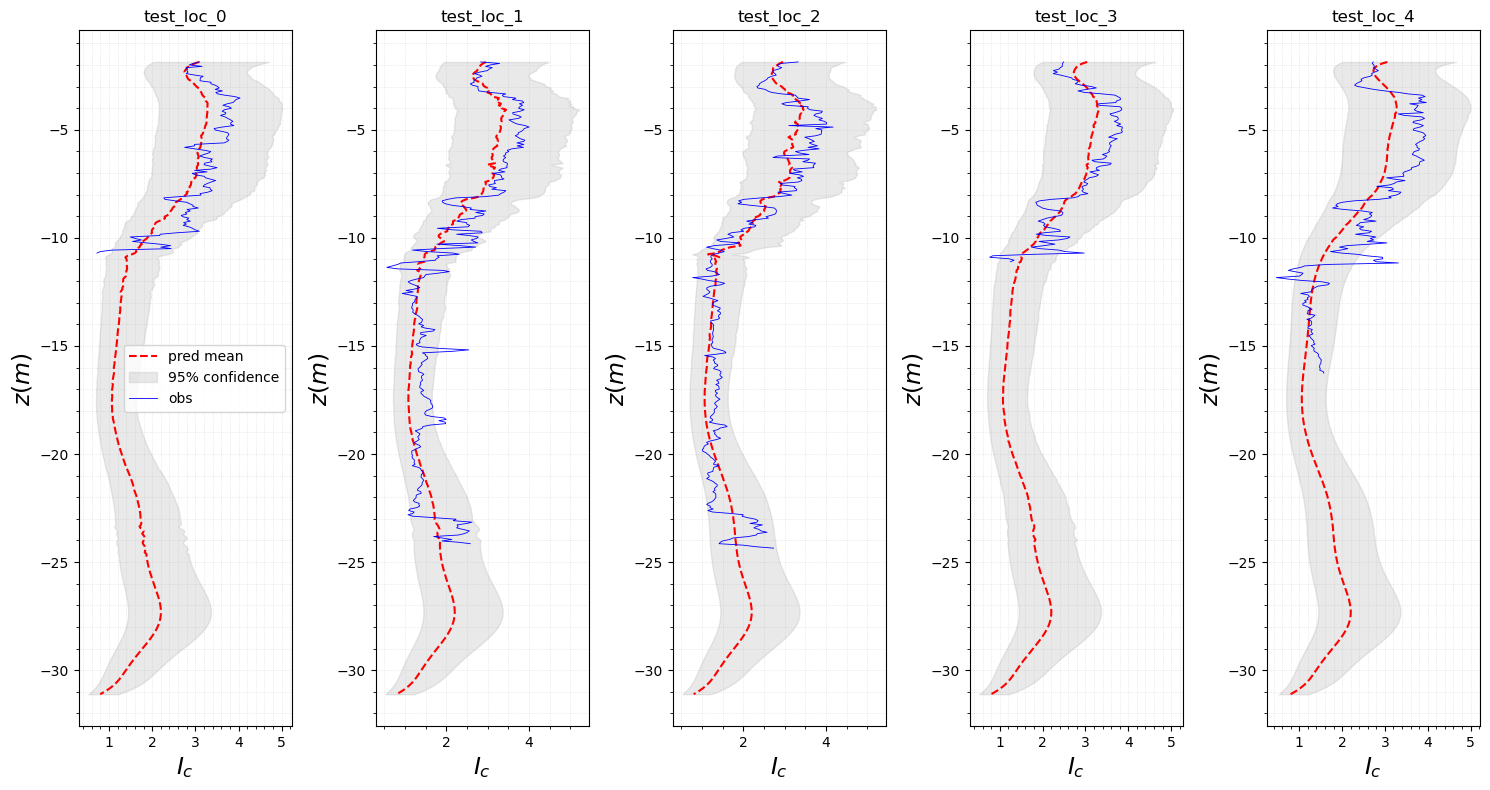

In [16]:
# =============================================================================
# Plots
# =============================================================================

par = "I_c"
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, len(x_t), figsize=(15, 8))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(mean_pred.reshape(n_h, n_v).T[:, cut_id], 
            -(z_t*(Dz+depth_0)+depth_0), '--',  color='red', label='pred mean')
    # Shade in confidence
    ax.fill_betweenx( -(z_t*(Dz+depth_0)+depth_0), upper_Z.reshape(n_h, n_v).T[:, cut_id], 
  lower_Z.reshape(n_h, n_v).T[:, cut_id], 
   color = "darkgrey", alpha = 0.25 , label='95% confidence')                   
    # plt.gca().invert_yaxis()
    # ax.set_ylim([-3, 3])
    ax.plot(np.exp(data_test[:, cut_id]), -(z_t*(Dz+depth_0)+depth_0), '-', color='blue', linewidth = 0.6, label='obs')
        # ax.plot((data_test[task][:, cut_id]), -z_test, 'o', color='blue',
        #         markersize = 1.0, label='observations')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    if par == "Ic":
        for xc in bounds:
            if xc == bounds[0]:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3, label = "robertson bounds")
            else:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3)
        
    ax.grid(which="both", color="darkgrey", alpha=.4, linewidth=0.5,linestyle=":")
    #plt.gca().invert_yaxis()
    ax.set_ylabel(r'$z (m)$ ', fontstyle='italic',fontsize = 17)
    ax.set_xlabel(task_names[0], fontstyle='italic',fontsize = 17)
    # ax.legend(['Observed Data', 'Mean', 'Confidence'])
    if i==0:
        ax.legend()
        # ax.set_xlim(0,3)

    ax.set_title("test_loc_"+str(i))
     # plt.gca().invert_yaxis()
#     fig.tight_layout()
fig.tight_layout()




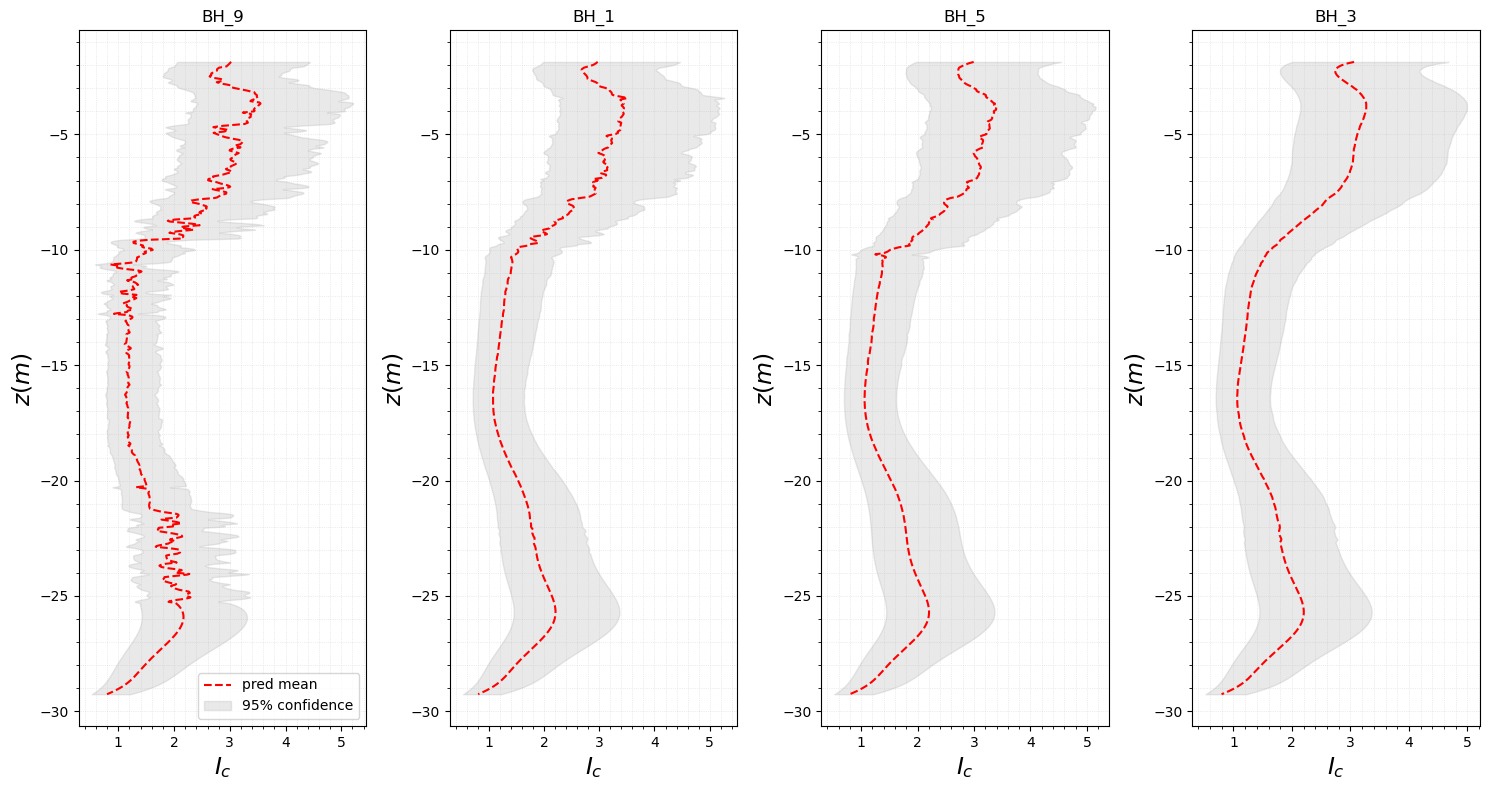

In [18]:
# -------------------------------------------------------------------------
# At borehole locations
# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m


x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 
z_t = np.linspace(0, np.max(grid[0].numpy()), 1000)
x_t = x_p_m
y_t = y_p_m

n_v = len(z_t)
n_h = len(x_t)

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).to(device).squeeze().t().to(dtype)

model.eval()
likelihood.eval()    

with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False, log_prob=True, solves=False),\
    gpytorch.settings.use_toeplitz(False):
    # test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    lower, upper = observed_pred.confidence_region()
    sigma = observed_pred.variance.sqrt()
    mean = observed_pred.mean
    
mean = mean.cpu()
sigma = sigma.cpu()
lower = lower.cpu()
upper = upper.cpu()
train_x_cpts = train_x_cpts.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

mean_pred = np.exp(mean.numpy()*std_cpt_log + mu_cpt_log)

lower_Z = np.exp(lower.numpy()*std_cpt_log + mu_cpt_log)
upper_Z = np.exp(upper.numpy()*std_cpt_log + mu_cpt_log)

depth_or = z_t*(Dz)+depth_0



BH_locs = ["BH_9", "BH_1", "BH_5", "BH_3"]   # with respect to x (see excel file)

bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, len(x_t), figsize=(15, 8))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(mean_pred.reshape(n_h, n_v).T[:, cut_id], 
            -(depth_or), '--',  color='red', label='pred mean')
    ax.fill_betweenx( -(depth_or), upper_Z.reshape(n_h, n_v).T[:, cut_id], 
                     lower_Z.reshape(n_h, n_v).T[:, cut_id], 
   color = "darkgrey", alpha = 0.25 , label='95% confidence')                   

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    if par == "Ic":
        for xc in bounds:
            if xc == bounds[0]:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3, label = "robertson bounds")
            else:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3)
        
    ax.grid(which="both", color="darkgrey", alpha=.4, linewidth=0.5,linestyle=":")
    ax.set_ylabel(r'$z (m)$ ', fontstyle='italic',fontsize = 17)
    ax.set_xlabel(task_names[0], fontstyle='italic',fontsize = 17)
    if i==0:
        ax.legend()

    ax.set_title(BH_locs[i])

fig.tight_layout()
# plt.savefig(plots_folder+"\\Ic_variational_loo_500it_438v_01lr_sbl_bhlocs"+'.png', 
#                 bbox_inches='tight', dpi=400)